# 0 Project Barley

Along this project we will work on various Barley's cultivar starting from Hv_Morex. The aim of this project is to further understand the importance of introns within genes and within Untranslated Regions (UTRs) and their differences. 

Another not secondary objective is to build a pipeline as much reproducible as possible. This notebook is meant to give readers a crystal clear view of how we proceeded to implement our work. 

All the work has been performed on a Linux machine running _Ubuntu 20.04.2 LTS x86_64_.

# 1 Working environment

**Before running the notebook** be sure to activate the conda environment shared with you:
- $ conda activate Pedroni_Thesis.yml

In [1]:
### --- This command can be installed with: $ sudo apt-get install neofetch
### --- It is used to show the software/hardware characteristics of the machine used to complete this project.
! neofetch | tail -22 | head -17

OS: Ubuntu 20.04.2 LTS x86_64 
Host: X580VD 1.0 
Kernel: 5.4.0-74-generic 
Uptime: 1 hour, 33 mins 
Packages: 2889 (dpkg), 5 (flatpak), 19 (snap) 
Shell: bash 5.0.17 
Resolution: 1920x1080 
DE: GNOME 
WM: Mutter 
WM Theme: Adwaita 
Theme: Orchis [GTK2/3] 
Icons: Tela-circle [GTK2/3] 
CPU: Intel i7-7700HQ (8) @ 3.800GHz 
GPU: NVIDIA GeForce GTX 1050 Mobile 
GPU: Intel HD Graphics 630 
Memory: 2702MiB / 15897MiB 



In [2]:
### --- This command is used to show you how directories should be organized to better be able to follow this work.
### --- The root directory of this project is called 'Project Barley'
! tree -d

.
├── Data
│   └── raw
├── Output
└── Scripts
    └── script_out

5 directories


# 2 Implementing an intron analysis on data from a long-read sequence assembly in Barley

The study I am referring to can be found [here](https://academic.oup.com/plcell/advance-article/doi/10.1093/plcell/koab077/6169005) while all the data can be found [here](https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/21172880-2956-4cbb-ab2c-5c00bceb08a2/0). 

## 2.1 Hv_Morex HC

### 2.1.1 Collecting Data

In [3]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/2492a5a9-08a8-4022-b6ad-9b056a00f64f/1/DOWNLOAD

--2021-06-03 16:19:52--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/2492a5a9-08a8-4022-b6ad-9b056a00f64f/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59307477 (57M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  56,56M  1,20MB/s    in 41s     

2021-06-03 16:20:34 (1,39 MB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3’ saved [59307477/59307477]



### 2.1.2 Processing data

In [1]:
### --- Importing the libraries needed to handle data and visualize them
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3

In [6]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv

In [7]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_MorexHC = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030
1,chr1H,pgsb,mRNA,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
3,chr1H,pgsb,CDS,76744,77373,.,+,0,ID=HORVU.MOREX.r3.1HG0000030.1.CDS1
4,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040


In [11]:
### --- Building a separate dataframe containing all exons
exon_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['exon'])]
exon_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
7,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
9,chr1H,pgsb,exon,79063,79104,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon2
11,chr1H,pgsb,exon,79609,79676,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon3
13,chr1H,pgsb,exon,79757,79799,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon4


In [12]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_MorexHC.to_csv('Data/Hv_MorexHC_exon.tsv',sep='\t',index=False,header=False)

In [14]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['strand'].isin(['+'])]
forw_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030
1,chr1H,pgsb,mRNA,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
3,chr1H,pgsb,CDS,76744,77373,.,+,0,ID=HORVU.MOREX.r3.1HG0000030.1.CDS1
48,chr1H,pgsb,gene,132221,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060


In [15]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['strand'].isin(['-'])]
rev_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
4,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040
5,chr1H,pgsb,mRNA,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1
6,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
7,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
8,chr1H,pgsb,CDS,78511,78954,.,-,0,ID=HORVU.MOREX.r3.1HG0000040.1.CDS1


In [16]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_MorexHC = forw_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
50,chr1H,pgsb,five_prime_UTR,132221,132375,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.five_prime_UTR1
93,chr1H,pgsb,three_prime_UTR,138505,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.three_prime_UTR2
97,chr1H,pgsb,five_prime_UTR,146607,146749,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR1
98,chr1H,pgsb,five_prime_UTR,146981,146996,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR2
103,chr1H,pgsb,three_prime_UTR,148229,148562,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.three_prime_UTR3


In [17]:
### --- Writing to a tsv formatted file the UTR_df_forw dataframe
UTR_forw_Hv_MorexHC.to_csv('Data/Hv_MorexHC_UTRforw.tsv',sep='\t',index=False,header=False)

In [18]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_MorexHC = rev_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
27,chr1H,pgsb,five_prime_UTR,81706,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.five_prime_UTR2
30,chr1H,pgsb,three_prime_UTR,84091,84317,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.three_prime_UTR1
47,chr1H,pgsb,five_prime_UTR,86846,87063,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.five_prime_UTR2
126,chr1H,pgsb,three_prime_UTR,156767,157203,.,-,.,ID=HORVU.MOREX.r3.1HG0000090.1.three_prime_UTR1


In [19]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_MorexHC.to_csv('Data/Hv_MorexHC_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.1.3 Extracting introns from the whole genome

In [2]:
### --- Function to extract introns from the whole genome
### --- Infile is a file like Hv_MorexHC_exon.tsv 
### --- Outfile will be written thanks to this function
### --- If there are two or more exons belonging to the same mRNA one after the other it compute the introns separating them
def extract_tot_introns(infile, outfile):
    introns = open(outfile, 'a') # Output/Hv_Morex_introns.tsv
    introns.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') 
    with open(infile) as f: # Data/Hv_Morex_exon.tsv
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines): # This is to avoid out of range error
                break 
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if '.'.join(line[8].split('.')[0:5]) != '.'.join(next_line[8].split('.')[0:5]): continue # Checking if the next exon has the same ID of the one we are at
                #print('The intron coordinates at %s are from %d to %d and the intron length is %d.' % (line[8][:30], int(line[4])+1, int(next_line[3])-1, int(next_line[3])-1 - int(line[4])+1))
                introns.write('\n'+'.'.join(line[8].split('.')[0:5])+'\t'+ 'intron ' +'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    introns.close()


In [21]:
### --- Extracting introns from Hv_MorexHC
extract_tot_introns('Data/Hv_MorexHC_exon.tsv', 'Output/Hv_MorexHC_introns.tsv')

In [22]:
introns_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_introns.tsv', sep = '\t')
introns_Hv_MorexHC[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0000250.1,intron,604220,604743,525
96,ID=HORVU.MOREX.r3.1HG0000260.1,intron,669330,669483,155
97,ID=HORVU.MOREX.r3.1HG0000260.1,intron,669685,669841,158
98,ID=HORVU.MOREX.r3.1HG0000280.1,intron,711070,711148,80


In [3]:
### --- Function to count introns within a dataframe made of exons formatted like exon_Hv_MorexHC
### --- If I use i[:28] I consider the gene, If I use i[:31] I'm at level of mRNA
### --- Actually using 31 I would avoid the problem of certain genes having >= 10 transcripts
def counting_introns_type(in_dataframe):
    counts = dict()
    for i in in_dataframe['attributes']:
        counts[i[:28]] = counts.get(i[:28], 0) + 1
    return counts

In [58]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_MorexHC = counting_introns_type(exon_Hv_MorexHC)

In [4]:
### --- Function to check intronless (no introns), intronpoor (<= 3 introns) and intron rich (> 3 introns)
### --- This division is made on the following assumption: n° introns = n° exons - 1
def splitting_introns_type(dictionary):
    intronless = 0
    intronpoor = 0
    intronrich = 0
    intronless_list = []
    intronpoor_list = []
    intronrich_list = []
    for i in dictionary:
        if dictionary[i] == 1:
            intronless += 1
            intronless_list.append(i)
        elif dictionary[i]>1 and dictionary[i]<= 4:
            intronpoor += 1
            intronpoor_list.append(i)
        elif dictionary[i] > 4:
            intronrich += 1
            intronrich_list.append(i)

    print('Intronless are: %d' % intronless)
    print('Intronpoor are: %d' % intronpoor)
    print('Intronrich are: %d' % intronrich)
    
    return (intronless, intronpoor, intronrich, intronless_list, intronpoor_list, intronrich_list)

In [106]:
n_intronless_Hv_MorexHC, n_intronpoor_Hv_MorexHC, n_intronrich_Hv_MorexHC, intronless_Hv_MorexHC, intronpoor_Hv_MorexHC, intronrich_Hv_MorexHC = splitting_introns_type(introns_dictionary_Hv_MorexHC)

Intronless are: 11537
Intronpoor are: 12997
Intronrich are: 11293


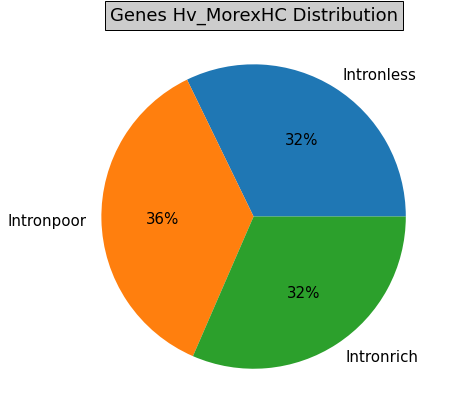

In [80]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data = [11537, 12997, 11293]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_MorexHC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [102]:
### --- Creating the list of Hv_MorexHC gene IDs to check the number of transcripts using command line
intronless_file = open('Output/Hv_MorexHC_intronlessIDs.txt', 'a')
intronpoor_file = open('Output/Hv_MorexHC_intronpoorIDs.txt', 'a')
intronrich_file = open('Output/Hv_MorexHC_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_MorexHC)):
    if i == len(intronless_Hv_MorexHC) -1:
        intronless_file.write(intronless_Hv_MorexHC[i])
    else:
        intronless_file.write(intronless_Hv_MorexHC[i] + '\n')
intronless_file.close()

for i in range(len(intronpoor_Hv_MorexHC)):
    if i == len(intronpoor_Hv_MorexHC) -1:
        intronpoor_file.write(intronpoor_Hv_MorexHC[i])
    else:
        intronpoor_file.write(intronpoor_Hv_MorexHC[i] + '\n')
intronpoor_file.close()

for i in range(len(intronrich_Hv_MorexHC)):
    if i == len(intronrich_Hv_MorexHC) -1:
        intronrich_file.write(intronrich_Hv_MorexHC[i])
    else:
        intronrich_file.write(intronrich_Hv_MorexHC[i]+'\n')
intronrich_file.close()


In [104]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [116]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_MorexHC = int(n_mRNA_intronless_Hv_MorexHC[0])/n_intronless_Hv_MorexHC
print(avg_mRNA_intronless_Hv_MorexHC)
avg_mRNA_intronpoor_Hv_MorexHC = int(n_mRNA_intronpoor_Hv_MorexHC[0])/n_intronpoor_Hv_MorexHC
print(avg_mRNA_intronpoor_Hv_MorexHC)
avg_mRNA_intronrich_Hv_MorexHC = int(n_mRNA_intronrich_Hv_MorexHC[0])/n_intronrich_Hv_MorexHC
print(avg_mRNA_intronrich_Hv_MorexHC)

1.0
1.0041548049549895
1.1843619941556716


### 2.1.4 Extracting introns from UTR regions

In [5]:
### --- Function to extract introns from UTR regions.
### --- Infile is a file like Hv_Morex_UTRforw_introns.tsv 
### --- Outfile will be written thanks to this function
### --- Being all on the same strand when two or more UTRs of the same type are one row after the other it means there is a intron separating them
def extract_UTR_introns(infile, outfile):
    UTR_introns_forw = open(outfile, 'a')
    UTR_introns_forw.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') # Defining the header
    with open(infile) as f:
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines):
                break
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if line[2] != next_line[2] or '.'.join(line[8].split('.')[0:5]) != '.'.join(next_line[8].split('.')[0:5]): continue
                #print('The intron coordinates at %s are from %d to %d and the intron length is %d.' % ('.'.join(line[8].split('.')[0:5]), int(line[4])+1, int(next_line[3])-1, int(next_line[3])-1 - int(line[4])+1))
                UTR_introns_forw.write('\n'+'.'.join(line[8].split('.')[0:5])+'\t'+ 'intron '+line[2]+'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    UTR_introns_forw.close()

In [33]:
### --- Extracting introns from UTR forward Hv_MorexHC
extract_UTR_introns('Data/Hv_MorexHC_UTRforw.tsv', 'Output/Hv_MorexHC_UTRforw_introns.tsv')

In [34]:
### --- Extracting introns from UTR reverse Hv_MorexHC
extract_UTR_introns('Data/Hv_MorexHC_UTRrev.tsv', 'Output/Hv_MorexHC_UTRrev_introns.tsv')

In [35]:
introns_UTR_forw_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [36]:
introns_UTR_rev_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000130.1,intron three_prime_UTR,377002,377104,104
1,ID=HORVU.MOREX.r3.1HG0000350.1,intron five_prime_UTR,1156130,1159354,3226
2,ID=HORVU.MOREX.r3.1HG0001120.1,intron five_prime_UTR,2577943,2580334,2393
3,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3193629,3198818,5191
4,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3198962,3199088,128


In [37]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames = [introns_UTR_forw_Hv_MorexHC, introns_UTR_rev_Hv_MorexHC]
introns_UTR_Hv_MorexHC = pd.concat(frames)

In [38]:
### --- Setting figure and font size
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.size"] = 15

In [39]:
### --- Performing some basic statistics 
introns_UTR_Hv_MorexHC['length'].describe()

count     5049.000000
mean       914.958210
std       2505.112829
min         33.000000
25%        121.000000
50%        406.000000
75%        943.000000
max      74239.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

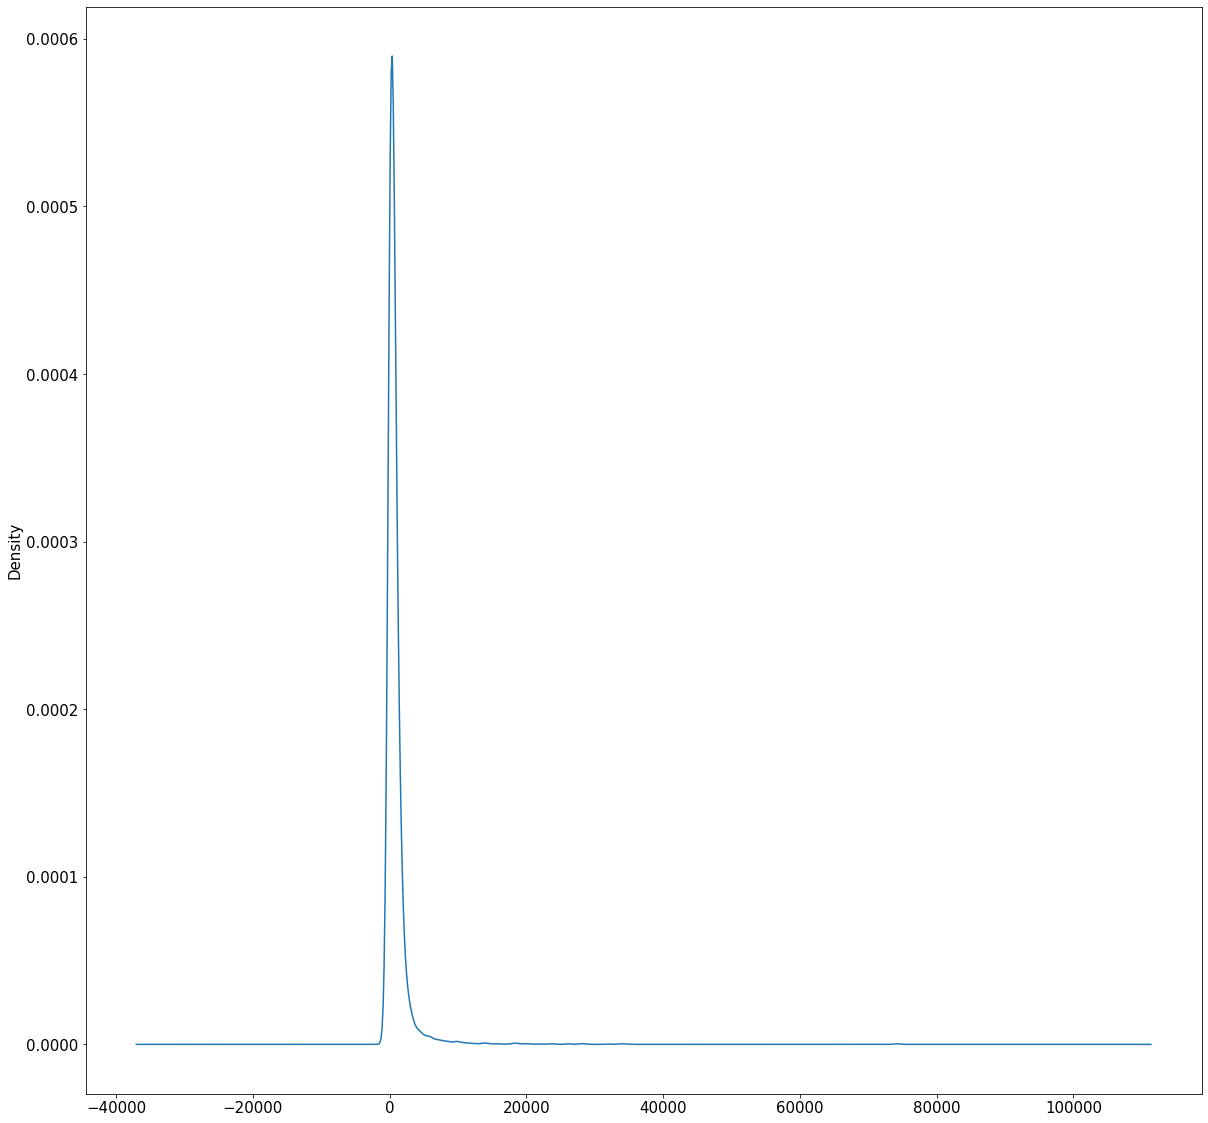

In [40]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_MorexHC['length'].plot.density()

<AxesSubplot:>

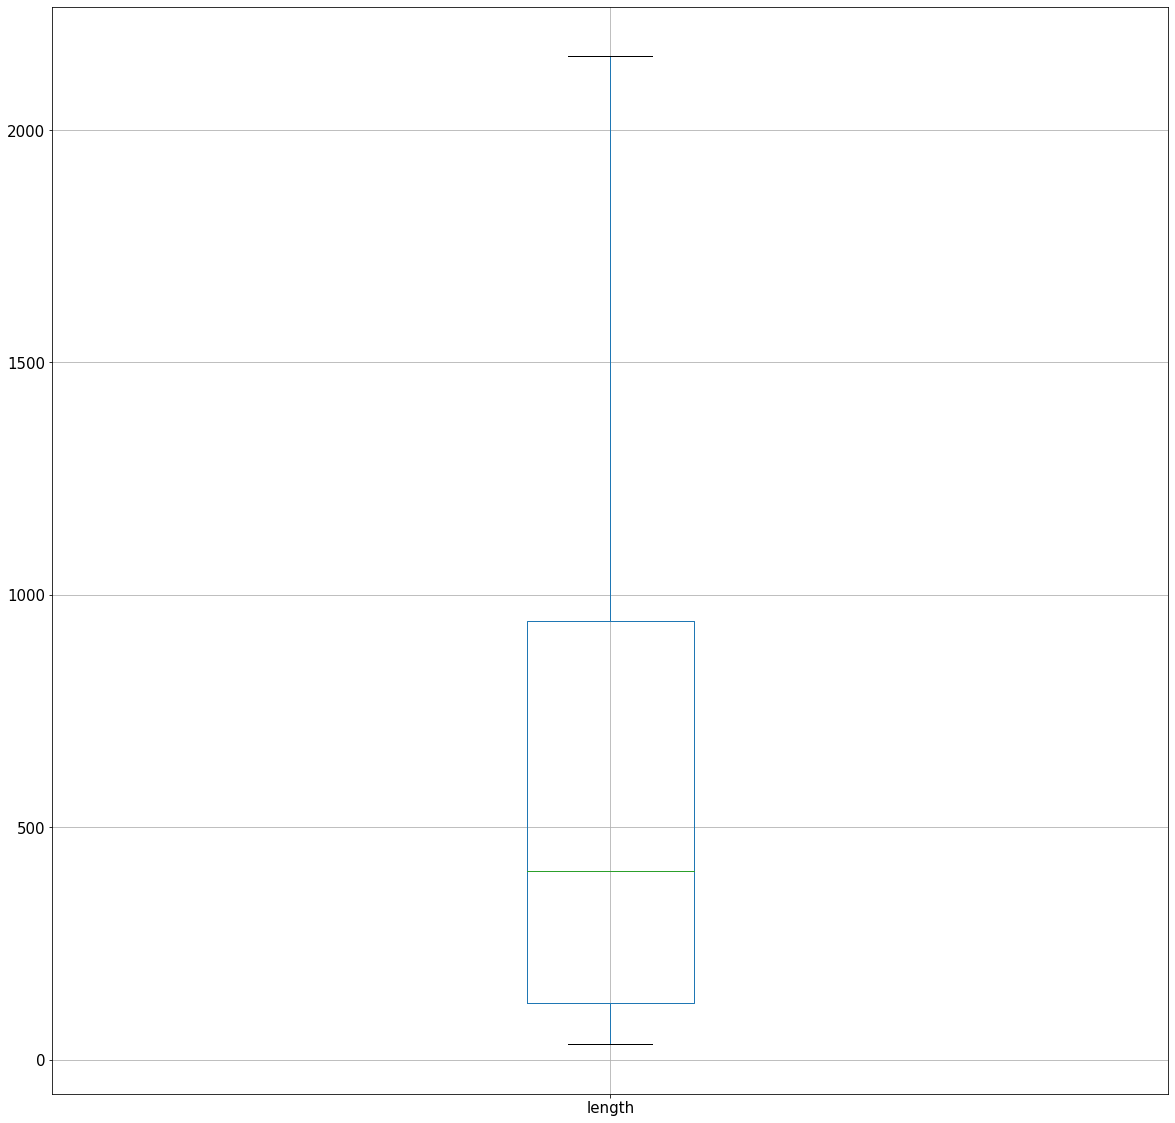

In [45]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_MorexHC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [54]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_MorexHC = introns_UTR_Hv_MorexHC.loc[introns_UTR_Hv_MorexHC['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_MorexHC = introns_UTR_Hv_MorexHC.loc[introns_UTR_Hv_MorexHC['type'].isin(['intron five_prime_UTR'])]


In [55]:
introns_UTR3_Hv_MorexHC

,ID,type,start,end,length
11,ID=HORVU.MOREX.r3.1HG0003090.2,intron three_prime_UTR,5946475,5974459,27986
12,ID=HORVU.MOREX.r3.1HG0003090.6,intron three_prime_UTR,5946475,5974459,27986
24,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14661381,14662100,721
25,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14662182,14662301,121
27,ID=HORVU.MOREX.r3.1HG0007370.2,intron three_prime_UTR,15093762,15093878,118
...,...,...,...,...,...
2406,ID=HORVU.MOREX.r3.7HG0748130.1,intron three_prime_UTR,620827612,620827821,211
2407,ID=HORVU.MOREX.r3.7HG0749430.1,intron three_prime_UTR,623175384,623176311,929
2408,ID=HORVU.MOREX.r3.7HG0749440.1,intron three_prime_UTR,623212429,623212835,408
2412,ID=HORVU.MOREX.r3.7HG0749980.1,intron three_prime_UTR,624202455,624203734,1281


In [118]:
introns_UTR3_Hv_MorexHC['length'].describe()

count     1632.000000
mean      1001.586397
std       3572.896832
min         33.000000
25%         99.000000
50%        196.000000
75%        750.500000
max      74239.000000
Name: length, dtype: float64

In [119]:
introns_UTR5_Hv_MorexHC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117
...,...,...,...,...,...
2416,ID=HORVU.MOREX.r3.7HG0751310.1,intron five_prime_UTR,627322202,627322296,96
2417,ID=HORVU.MOREX.r3.7HG0752050.1,intron five_prime_UTR,628813527,628813619,94
2419,ID=HORVU.MOREX.r3.7HG0752950.1,intron five_prime_UTR,632146924,632147308,386
2420,ID=HORVU.MOREX.r3.UnG0753140.1,intron five_prime_UTR,475717,475945,230


In [120]:
introns_UTR5_Hv_MorexHC['length'].describe()

count     3417.000000
mean       873.583553
std       1781.409570
min         41.000000
25%        150.000000
50%        511.000000
75%        997.000000
max      34933.000000
Name: length, dtype: float64

### 2.1.5 Removing UTR introns from the whole introns dataframe

In [64]:
### --- Checking total introns dataframe 
introns_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553


In [65]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [6]:
### --- Function to create remove from the total introns the one within UTRs and create a dataframe with introns within cds
### --- The indataframe must be formatted like introns_Hv_MorexHC
### --- The assumption is to use pd.concat() to concatenate the two dataframes and then drop the duplicates
def cds_introns_dataframe(indataframe1, indataframe2):
    total_introns_df = pd.concat([indataframe1,indataframe2])
    #print(len(total_introns_df))
    #print(len(introns_UTR))
    #print(len(introns_df))
    #print(len(total_introns_df.drop_duplicates(['ID','start','end'],keep=False))) 
    introns_cds_df = total_introns_df.drop_duplicates(['ID','start','end'],keep=False)
    return introns_cds_df

In [67]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_MorexHC = cds_introns_dataframe(introns_Hv_MorexHC, introns_UTR_Hv_MorexHC)
introns_cds_Hv_MorexHC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553
...,...,...,...,...,...
131226,ID=HORVU.MOREX.r3.UnG0816010.1,intron,28860551,28860786,237
131227,ID=HORVU.MOREX.r3.UnG0816010.1,intron,28861622,28861672,52
131228,ID=HORVU.MOREX.r3.UnG0816040.1,intron,28867800,28867889,91
131229,ID=HORVU.MOREX.r3.UnG0816160.1,intron,28884605,28884809,206


In [68]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_MorexHC.loc[introns_cds_Hv_MorexHC['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [73]:
### --- Basic statistics of Hv_MorexHC introns cds
introns_cds_Hv_MorexHC['length'].describe()

count    126182.000000
mean        565.209444
std        2222.947337
min          22.000000
25%          94.000000
50%         131.000000
75%         439.000000
max      234533.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

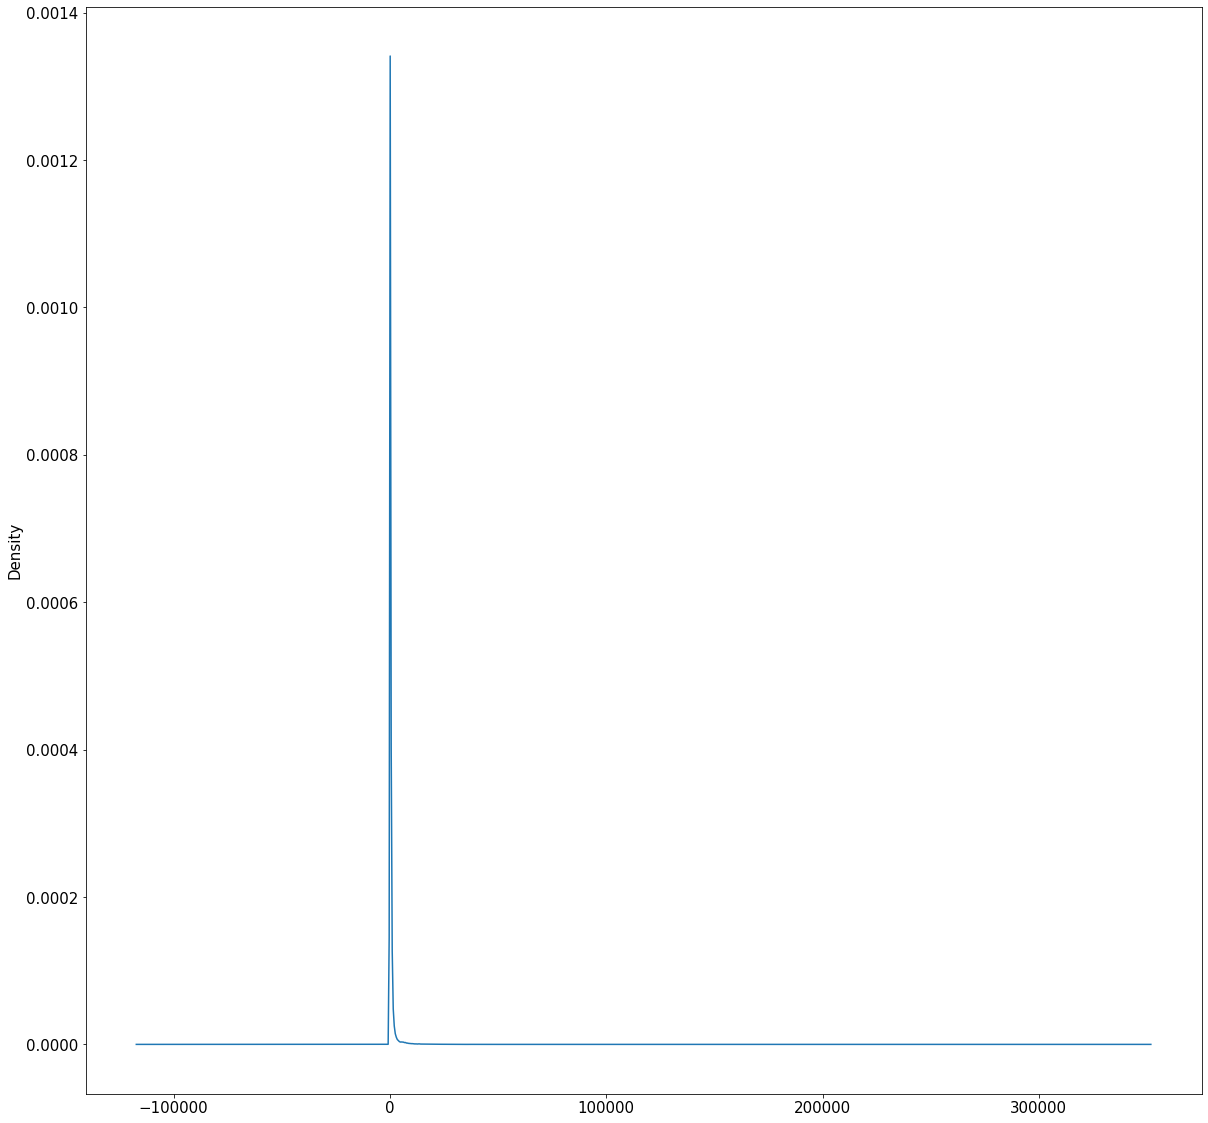

In [74]:
### --- Plotting the distribution of Hv_MorexHC cds introns length
introns_cds_Hv_MorexHC['length'].plot.density()

<AxesSubplot:>

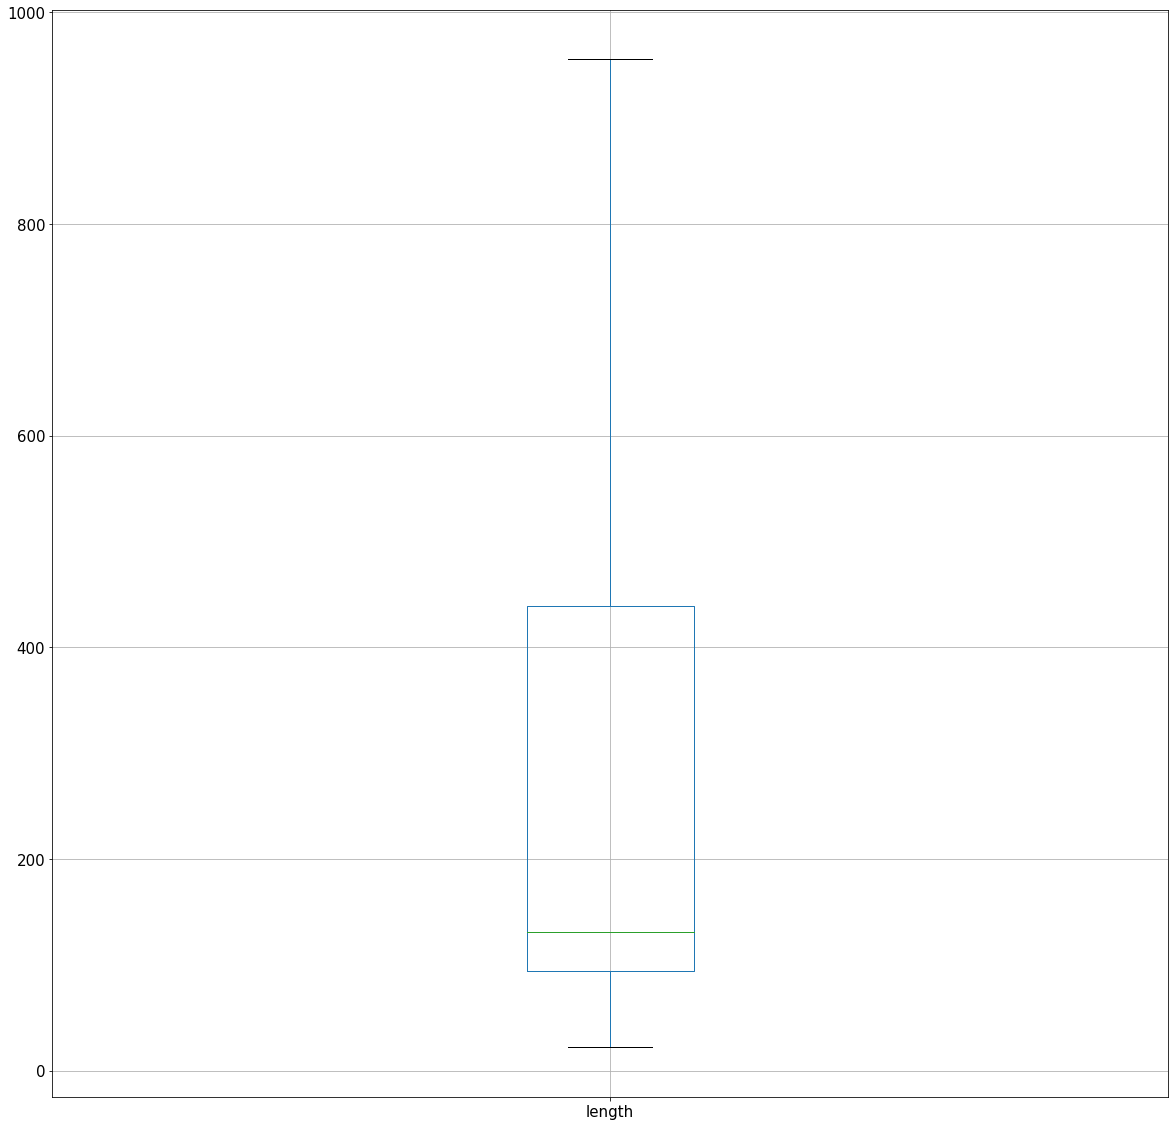

In [79]:
### --- Plotting the boxplot of Hv_MorexHC cds introns length without outliers
introns_cds_Hv_MorexHC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.1.6 Re-organizing files and directories

In [133]:
! ls Data/

Hv_MorexHC_exon.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_MorexHC_UTRforw.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexHC_UTRrev.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.gff3  raw


In [134]:
! mkdir Data/Hv_Morex_longread

In [135]:
! mv Data/Hv_MorexHC* Data/Hv_Morex_longread/

In [136]:
! ls Data/Hv_Morex_longread/

Hv_MorexHC_exon.tsv  Hv_MorexHC_UTRforw.tsv  Hv_MorexHC_UTRrev.tsv


In [121]:
! ls Output/

Hv_MorexHC_intronlessIDs.txt  Hv_MorexHC_introns.tsv
Hv_MorexHC_intronpoorIDs.txt  Hv_MorexHC_UTRforw_introns.tsv
Hv_MorexHC_intronrichIDs.txt  Hv_MorexHC_UTRrev_introns.tsv


In [126]:
! mkdir Output/Hv_Morex_longread

In [127]:
! mv Output/Hv_MorexHC* Output/Hv_Morex_longread

In [128]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt  Hv_MorexHC_introns.tsv
Hv_MorexHC_intronpoorIDs.txt  Hv_MorexHC_UTRforw_introns.tsv
Hv_MorexHC_intronrichIDs.txt  Hv_MorexHC_UTRrev_introns.tsv


# 2.2 Reproducing on Hv_Morex LC

### 2.2.1 Collecting Data

In [129]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/e27077bd-fa0b-4c20-ba87-5c84b9d0641c/1/DOWNLOAD

--2021-06-03 18:19:52--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/e27077bd-fa0b-4c20-ba87-5c84b9d0641c/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36401810 (35M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  34,71M  1,41MB/s    in 20s     

2021-06-03 18:20:13 (1,74 MB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3’ saved [36401810/36401810]



### 2.2.2 Processing Data

In [138]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [131]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3

In [139]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv

In [140]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_MorexLC = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [141]:
### --- Building a separate dataframe containing all exons
exon_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['exon'])]
exon_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
6,chr1H,pgsb,exon,50195,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon2
10,chr1H,pgsb,exon,53979,54323,.,+,.,ID=HORVU.MOREX.r3.1HG0000020.1.exon1
15,chr1H,pgsb,exon,161529,162712,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon1
17,chr1H,pgsb,exon,162818,163068,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon2


In [142]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_MorexLC.to_csv('Data/Hv_MorexLC_exon.tsv',sep='\t',index=False,header=False)

In [143]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['strand'].isin(['+'])]
forw_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [144]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['strand'].isin(['-'])]
rev_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
12,chr1H,pgsb,gene,161529,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100
13,chr1H,pgsb,mRNA,161529,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1
14,chr1H,pgsb,three_prime_UTR,161529,161892,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.three_prime_UTR1
15,chr1H,pgsb,exon,161529,162712,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon1
16,chr1H,pgsb,CDS,161893,162712,.,-,1,ID=HORVU.MOREX.r3.1HG0000100.1.CDS1


In [145]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_MorexLC = forw_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
7,chr1H,pgsb,three_prime_UTR,50428,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.three_prime_UTR2
693,chr1H,pgsb,five_prime_UTR,7942206,7942870,.,+,.,ID=HORVU.MOREX.r3.1HG0003730.1.five_prime_UTR1
1826,chr1H,pgsb,three_prime_UTR,16128825,16128956,.,+,.,ID=HORVU.MOREX.r3.1HG0007720.1.three_prime_UTR1
2009,chr1H,pgsb,five_prime_UTR,17860934,17860983,.,+,.,ID=HORVU.MOREX.r3.1HG0008240.1.five_prime_UTR1


In [146]:
### --- Writing to a tsv formatted file the UTR_df_forw dataframe
UTR_forw_Hv_MorexLC.to_csv('Data/Hv_MorexLC_UTRforw.tsv',sep='\t',index=False,header=False)

In [147]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_MorexLC = rev_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
14,chr1H,pgsb,three_prime_UTR,161529,161892,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.three_prime_UTR1
23,chr1H,pgsb,five_prime_UTR,166559,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.five_prime_UTR2
496,chr1H,pgsb,three_prime_UTR,5367715,5367998,.,-,.,ID=HORVU.MOREX.r3.1HG0002620.1.three_prime_UTR1
500,chr1H,pgsb,five_prime_UTR,5370295,5370423,.,-,.,ID=HORVU.MOREX.r3.1HG0002620.1.five_prime_UTR2
704,chr1H,pgsb,five_prime_UTR,7998340,7998963,.,-,.,ID=HORVU.MOREX.r3.1HG0003750.1.five_prime_UTR1


In [148]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_MorexLC.to_csv('Data/Hv_MorexLC_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.2.3 Extracting introns from the whole genome

In [149]:
### --- Extracting introns from Hv_MorexLC
extract_tot_introns('Data/Hv_MorexLC_exon.tsv', 'Output/Hv_MorexLC_introns.tsv')

In [150]:
introns_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_introns.tsv', sep = '\t')
introns_Hv_MorexLC[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818290,8818371,83
96,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818465,8818552,89
97,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818763,8818850,89
98,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8819105,8819191,88


In [151]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_MorexLC = counting_introns_type(exon_Hv_MorexLC)

In [152]:
n_intronless_Hv_MorexLC, n_intronpoor_Hv_MorexLC, n_intronrich_Hv_MorexLC, intronless_Hv_MorexLC, intronpoor_Hv_MorexLC, intronrich_Hv_MorexLC = splitting_introns_type(introns_dictionary_Hv_MorexLC)

Intronless are: 34638
Intronpoor are: 9345
Intronrich are: 1877


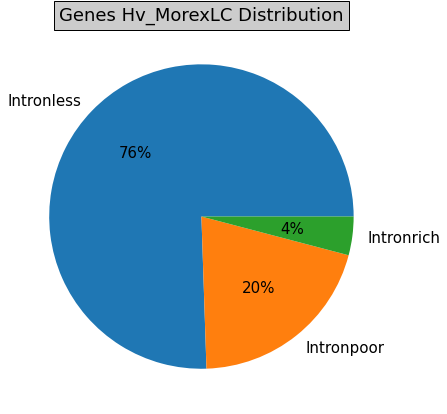

In [156]:
data_Hv_MorexLC = [34638, 9345, 1877]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Hv_MorexLC, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_MorexLC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [160]:
### --- Creating the list of Hv_MorexLC gene IDs to check the number of transcripts using command line
intronless_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronlessIDs.txt', 'a')
intronpoor_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronpoorIDs.txt', 'a')
intronrich_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_MorexLC)):
    if i == len(intronless_Hv_MorexLC) -1:
        intronless_file_Hv_Morex_LC.write(intronless_Hv_MorexLC[i])
    else:
        intronless_file_Hv_Morex_LC.write(intronless_Hv_MorexLC[i] + '\n')
intronless_file_Hv_Morex_LC.close()

for i in range(len(intronpoor_Hv_MorexLC)):
    if i == len(intronpoor_Hv_MorexLC) -1:
        intronpoor_file_Hv_Morex_LC.write(intronpoor_Hv_MorexLC[i])
    else:
        intronpoor_file_Hv_Morex_LC.write(intronpoor_Hv_MorexLC[i] + '\n')
intronpoor_file_Hv_Morex_LC.close()

for i in range(len(intronrich_Hv_MorexLC)):
    if i == len(intronrich_Hv_MorexLC) -1:
        intronrich_file_Hv_Morex_LC.write(intronrich_Hv_MorexLC[i])
    else:
        intronrich_file_Hv_Morex_LC.write(intronrich_Hv_MorexLC[i]+'\n')
intronrich_file_Hv_Morex_LC.close()


In [161]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [162]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_MorexLC = int(n_mRNA_intronless_Hv_MorexLC[0])/n_intronless_Hv_MorexLC
print(avg_mRNA_intronless_Hv_MorexLC)
avg_mRNA_intronpoor_Hv_MorexLC = int(n_mRNA_intronpoor_Hv_MorexLC[0])/n_intronpoor_Hv_MorexLC
print(avg_mRNA_intronpoor_Hv_MorexLC)
avg_mRNA_intronrich_Hv_MorexLC = int(n_mRNA_intronrich_Hv_MorexLC[0])/n_intronrich_Hv_MorexLC
print(avg_mRNA_intronrich_Hv_MorexLC)

1.0
1.000749063670412
1.0852424080980287


### 2.2.4 Extracting introns from UTR regions

In [163]:
### --- Extracting introns from UTR forward Hv_MorexLC
extract_UTR_introns('Data/Hv_MorexLC_UTRforw.tsv', 'Output/Hv_MorexLC_UTRforw_introns.tsv')

In [164]:
### --- Extracting introns from UTR reverse Hv_MorexLC
extract_UTR_introns('Data/Hv_MorexLC_UTRrev.tsv', 'Output/Hv_MorexLC_UTRrev_introns.tsv')

In [165]:
introns_UTR_forw_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92


In [166]:
introns_UTR_rev_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0014180.1,intron five_prime_UTR,36894157,36894895,740
1,ID=HORVU.MOREX.r3.1HG0014180.2,intron five_prime_UTR,36894157,36894774,619
2,ID=HORVU.MOREX.r3.1HG0016500.1,intron three_prime_UTR,48532571,48532662,93
3,ID=HORVU.MOREX.r3.1HG0016500.1,intron three_prime_UTR,48532748,48533976,1230
4,ID=HORVU.MOREX.r3.1HG0016500.2,intron three_prime_UTR,48530961,48532662,1703


In [167]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames_Hv_MorexLC = [introns_UTR_forw_Hv_MorexLC, introns_UTR_rev_Hv_MorexLC]
introns_UTR_Hv_MorexLC = pd.concat(frames_Hv_MorexLC)

In [169]:
### --- Performing some basic statistics 
introns_UTR_Hv_MorexLC['length'].describe()

count      662.000000
mean       762.001511
std       1953.932847
min         60.000000
25%        105.250000
50%        265.500000
75%        844.750000
max      30548.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

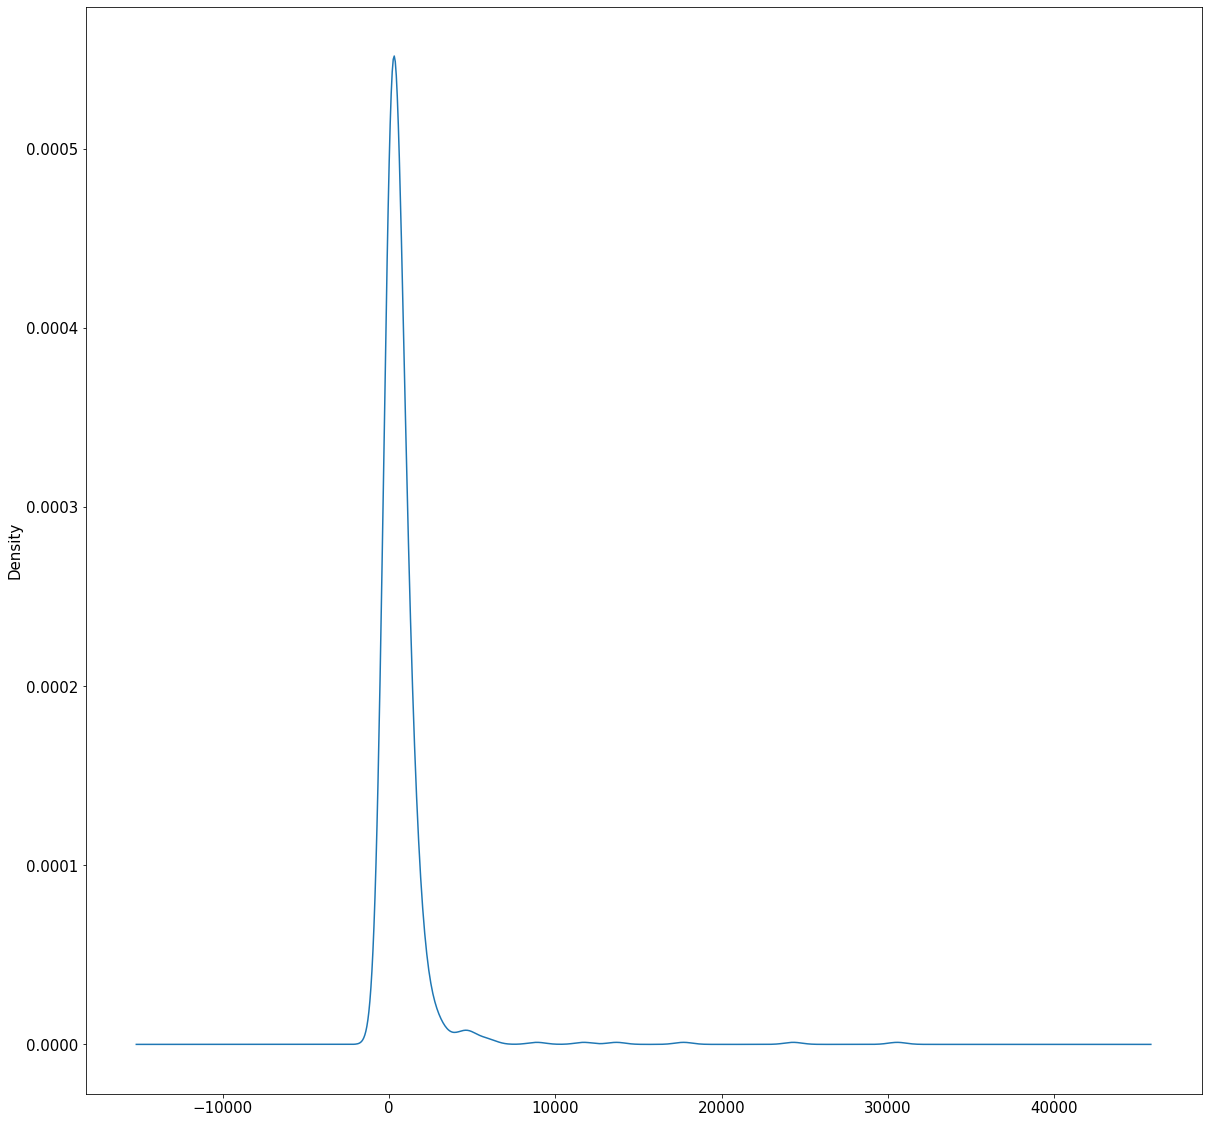

In [170]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_MorexLC['length'].plot.density()

<AxesSubplot:>

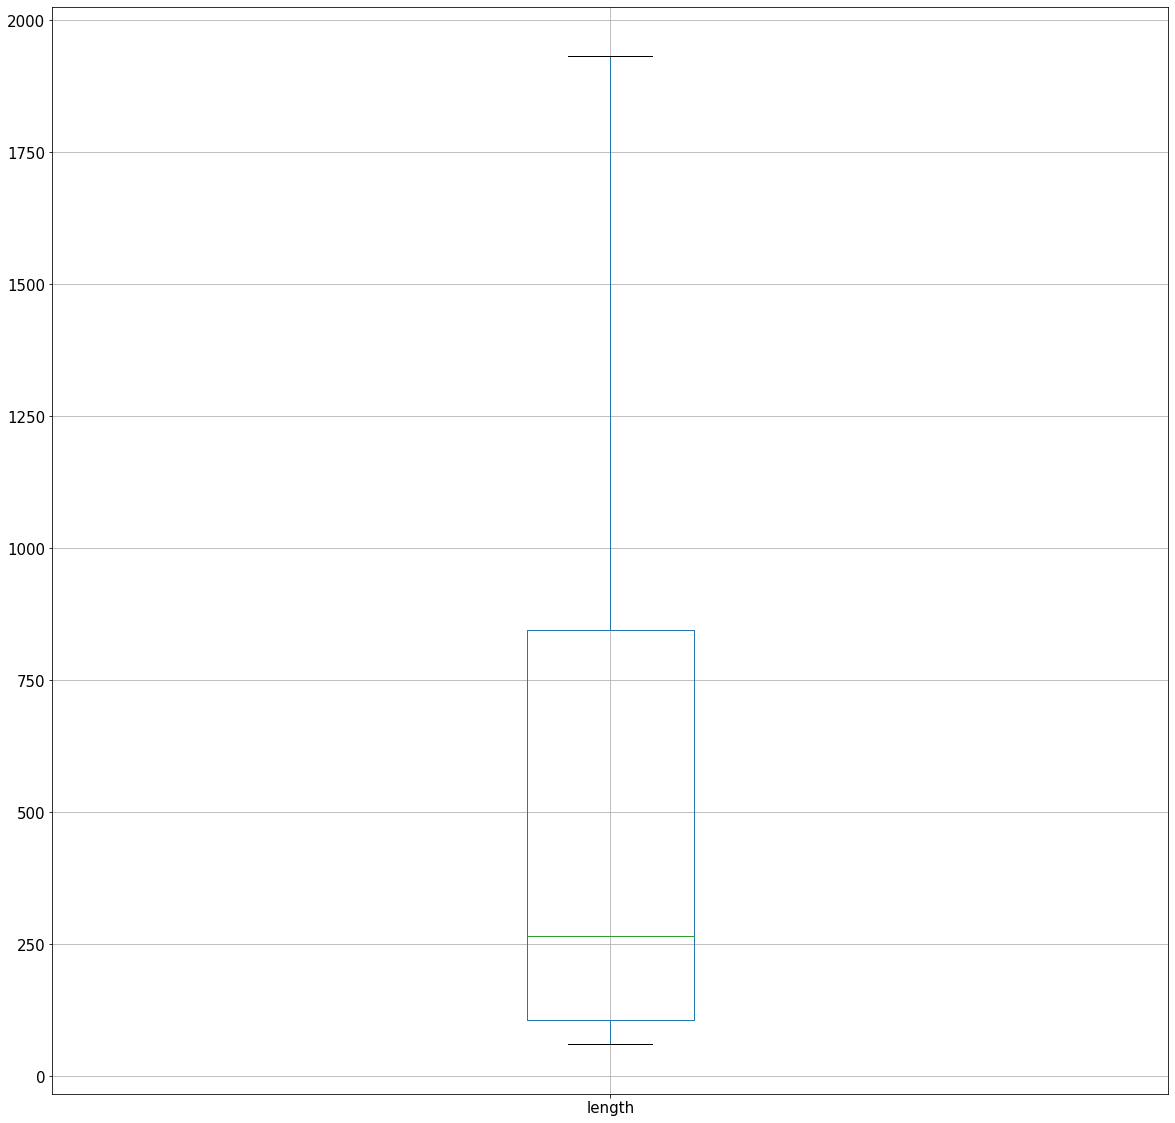

In [171]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_MorexLC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [172]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_MorexLC = introns_UTR_Hv_MorexLC.loc[introns_UTR_Hv_MorexLC['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_MorexLC = introns_UTR_Hv_MorexLC.loc[introns_UTR_Hv_MorexLC['type'].isin(['intron five_prime_UTR'])]

In [173]:
introns_UTR3_Hv_MorexLC

,ID,type,start,end,length
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92
8,ID=HORVU.MOREX.r3.1HG0040200.1,intron three_prime_UTR,254273004,254273075,73
9,ID=HORVU.MOREX.r3.1HG0040200.1,intron three_prime_UTR,254273172,254273252,82
...,...,...,...,...,...
256,ID=HORVU.MOREX.r3.7HG0686700.4,intron three_prime_UTR,225674132,225674643,513
260,ID=HORVU.MOREX.r3.7HG0690620.1,intron three_prime_UTR,264611386,264612013,629
261,ID=HORVU.MOREX.r3.7HG0693690.1,intron three_prime_UTR,306366598,306367589,993
264,ID=HORVU.MOREX.r3.7HG0697870.1,intron three_prime_UTR,360535445,360536998,1555


In [176]:
introns_UTR3_Hv_MorexLC['length'].describe()

count      380.000000
mean       822.815789
std       2185.413050
min         64.000000
25%        105.000000
50%        298.000000
75%        844.250000
max      30548.000000
Name: length, dtype: float64

In [174]:
introns_UTR5_Hv_MorexLC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
5,ID=HORVU.MOREX.r3.1HG0036900.1,intron five_prime_UTR,220266901,220267015,116
6,ID=HORVU.MOREX.r3.1HG0036900.1,intron five_prime_UTR,220267198,220267704,508
7,ID=HORVU.MOREX.r3.1HG0036900.2,intron five_prime_UTR,220266901,220267015,116
...,...,...,...,...,...
263,ID=HORVU.MOREX.r3.7HG0695870.1,intron five_prime_UTR,335796573,335796877,306
265,ID=HORVU.MOREX.r3.7HG0697870.1,intron five_prime_UTR,360537796,360537891,97
266,ID=HORVU.MOREX.r3.7HG0704470.1,intron five_prime_UTR,422495764,422495886,124
268,ID=HORVU.MOREX.r3.7HG0717650.1,intron five_prime_UTR,511731957,511732038,83


In [177]:
introns_UTR5_Hv_MorexLC['length'].describe()

count      282.000000
mean       680.053191
std       1589.765537
min         60.000000
25%        106.000000
50%        240.500000
75%        838.750000
max      24296.000000
Name: length, dtype: float64

### 2.2.5 Removing UTR introns from the whole introns dataframe

In [178]:
### --- Checking total introns dataframe 
introns_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286


In [179]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92


In [180]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_MorexLC = cds_introns_dataframe(introns_Hv_MorexLC, introns_UTR_Hv_MorexLC)
introns_cds_Hv_MorexLC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286
...,...,...,...,...,...
25451,ID=HORVU.MOREX.r3.UnG0816300.1,intron,28901487,28901588,103
25452,ID=HORVU.MOREX.r3.UnG0816640.1,intron,29002646,29003296,652
25453,ID=HORVU.MOREX.r3.UnG0816680.1,intron,29008046,29008730,686
25454,ID=HORVU.MOREX.r3.UnG0816840.1,intron,29079790,29086201,6413


In [181]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_MorexLC.loc[introns_cds_Hv_MorexLC['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [182]:
### --- Basic statistics of Hv_MorexLC introns cds
introns_cds_Hv_MorexLC['length'].describe()

count     24794.000000
mean        487.854602
std        3634.413380
min          22.000000
25%          88.000000
50%         110.500000
75%         314.000000
max      500805.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

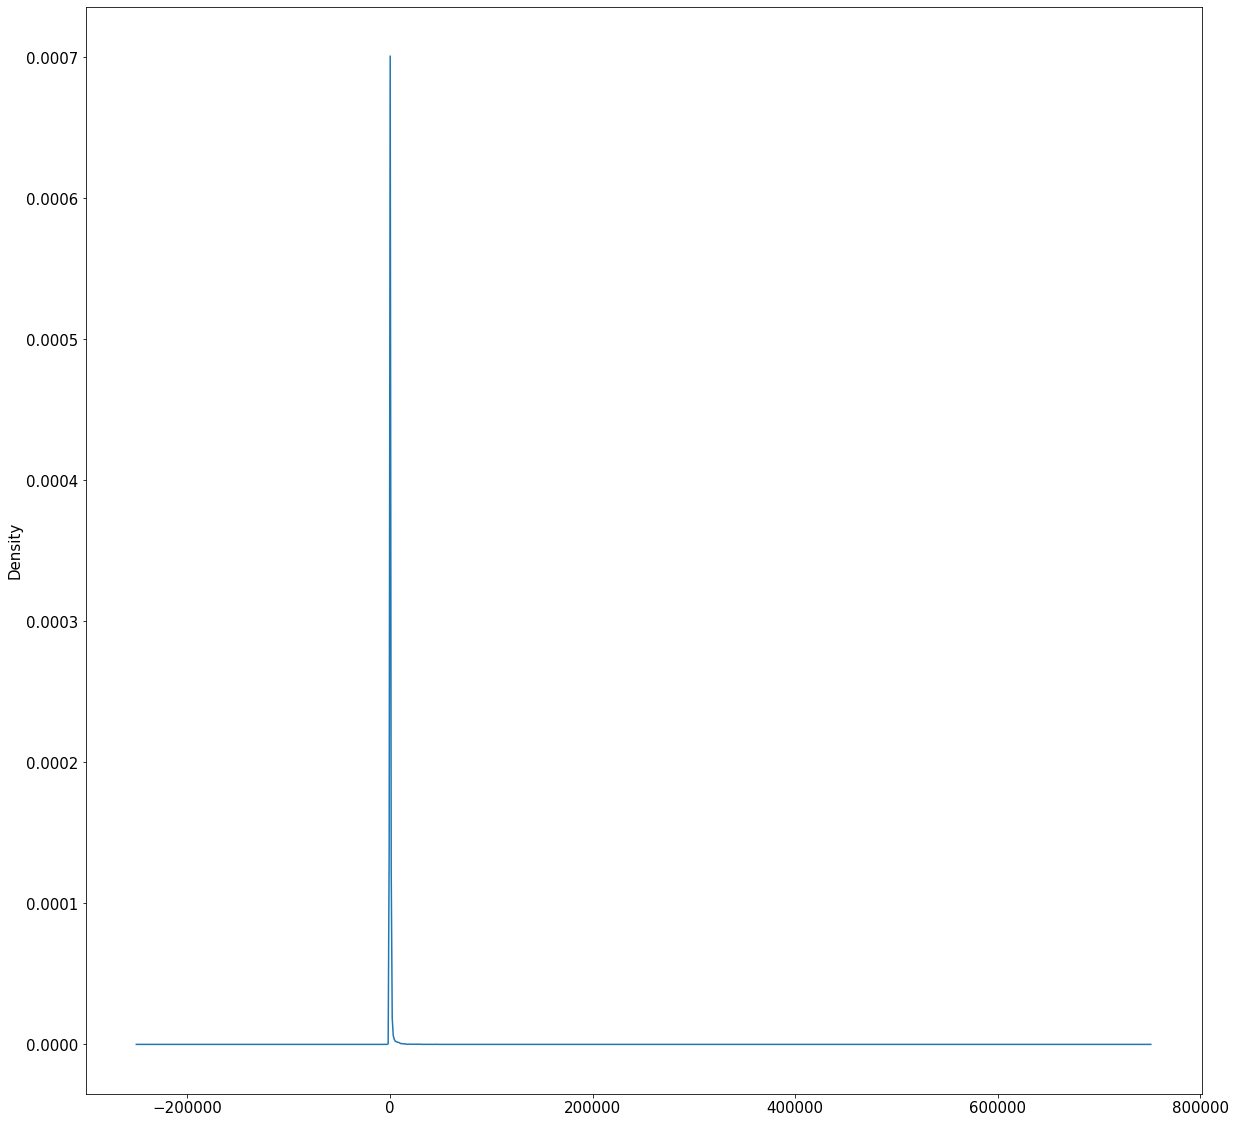

In [183]:
### --- Plotting the distribution of Hv_MorexLC cds introns length
introns_cds_Hv_MorexLC['length'].plot.density()

<AxesSubplot:>

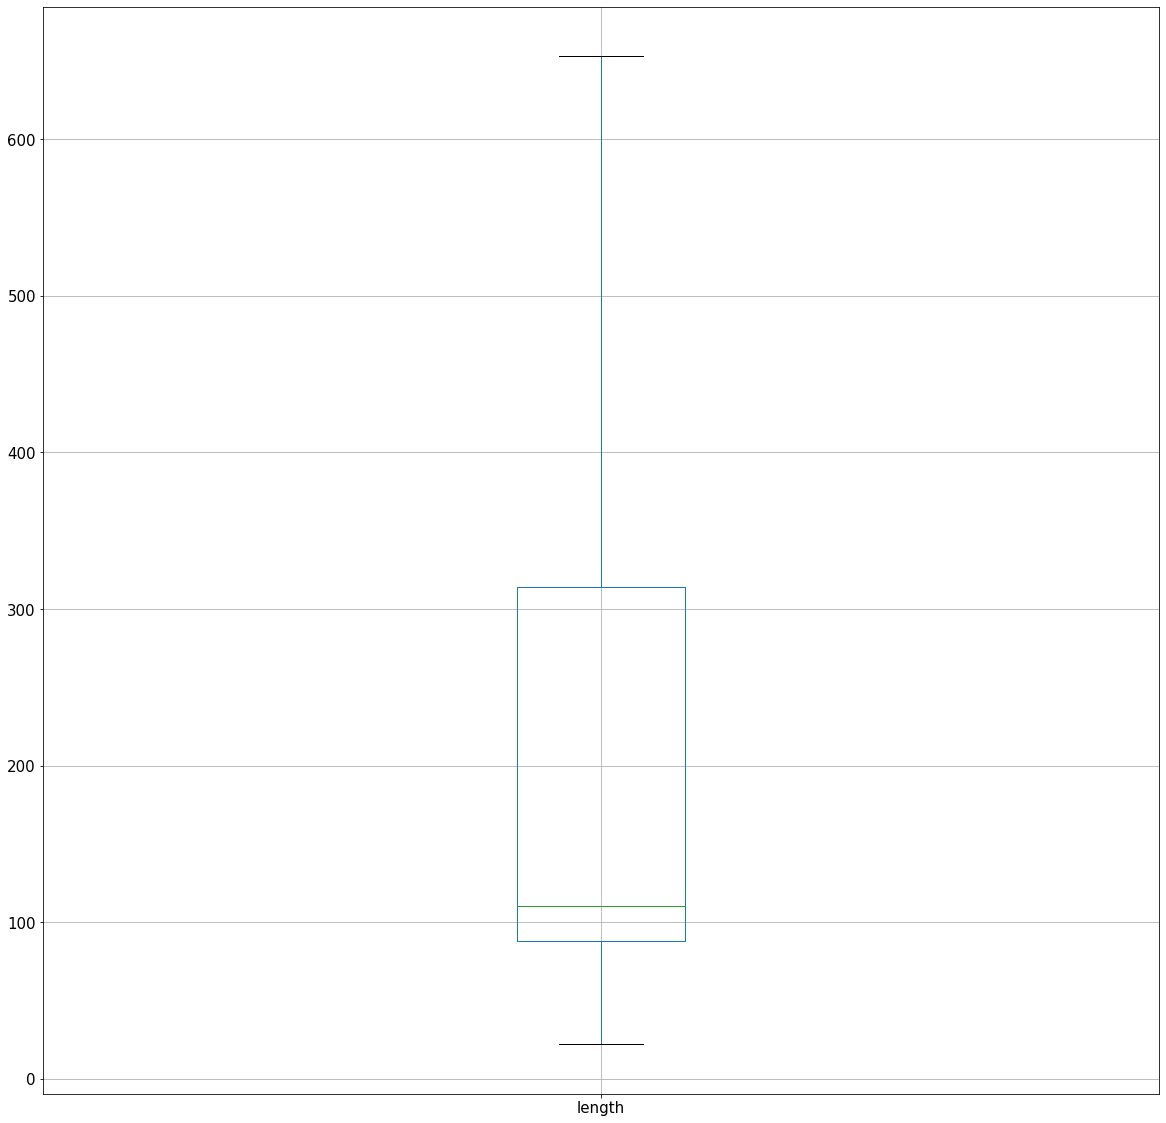

In [184]:
### --- Plotting the boxplot of Hv_MorexLC cds introns length without outliers
introns_cds_Hv_MorexLC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.2.6 Re-organizing files and directories

In [185]:
! ls Data/

Hv_MorexLC_exon.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_MorexLC_UTRforw.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexLC_UTRrev.tsv		      Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_Morex_longread		      Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.gff3  raw


In [186]:
! mv Data/Hv_MorexLC* Data/Hv_Morex_longread/

In [187]:
! ls Data/Hv_Morex_longread/

Hv_MorexHC_exon.tsv	Hv_MorexHC_UTRrev.tsv  Hv_MorexLC_UTRforw.tsv
Hv_MorexHC_UTRforw.tsv	Hv_MorexLC_exon.tsv    Hv_MorexLC_UTRrev.tsv


In [188]:
! ls Output/

Hv_MorexLC_intronlessIDs.txt  Hv_MorexLC_introns.tsv	      Hv_Morex_longread
Hv_MorexLC_intronpoorIDs.txt  Hv_MorexLC_UTRforw_introns.tsv
Hv_MorexLC_intronrichIDs.txt  Hv_MorexLC_UTRrev_introns.tsv


In [189]:
! mv Output/Hv_MorexLC* Output/Hv_Morex_longread/

In [190]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt	Hv_MorexLC_intronlessIDs.txt
Hv_MorexHC_intronpoorIDs.txt	Hv_MorexLC_intronpoorIDs.txt
Hv_MorexHC_intronrichIDs.txt	Hv_MorexLC_intronrichIDs.txt
Hv_MorexHC_introns.tsv		Hv_MorexLC_introns.tsv
Hv_MorexHC_UTRforw_introns.tsv	Hv_MorexLC_UTRforw_introns.tsv
Hv_MorexHC_UTRrev_introns.tsv	Hv_MorexLC_UTRrev_introns.tsv


# 2.3 Reproducing on Hv_Morex total

### 2.3.1 Collecting Data

In [130]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD 

--2021-06-03 18:21:54--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95708927 (91M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  91,27M  1,57MB/s    in 64s     

2021-06-03 18:22:58 (1,44 MB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.gff3’ saved [95708927/95708927]



### 2.3.2 Processing Data

In [1]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [132]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3

In [2]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.csv

In [5]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_Morex = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [6]:
### --- Building a separate dataframe containing all exons
exon_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['type'].isin(['exon'])]
exon_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
6,chr1H,pgsb,exon,50195,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon2
10,chr1H,pgsb,exon,53979,54323,.,+,.,ID=HORVU.MOREX.r3.1HG0000020.1.exon1
14,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
19,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1


In [7]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_Morex.to_csv('Data/Hv_Morex_exon.tsv',sep='\t',index=False,header=False)

In [8]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['strand'].isin(['+'])]
forw_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [10]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['strand'].isin(['-'])]
rev_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
16,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040
17,chr1H,pgsb,mRNA,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1
18,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
19,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
20,chr1H,pgsb,CDS,78511,78954,.,-,0,ID=HORVU.MOREX.r3.1HG0000040.1.CDS1


In [11]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_Morex = forw_Hv_Morex.loc[df_Hv_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
7,chr1H,pgsb,three_prime_UTR,50428,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.three_prime_UTR2
62,chr1H,pgsb,five_prime_UTR,132221,132375,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.five_prime_UTR1
105,chr1H,pgsb,three_prime_UTR,138505,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.three_prime_UTR2
109,chr1H,pgsb,five_prime_UTR,146607,146749,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR1


In [12]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_forw_Hv_Morex.to_csv('Data/Hv_Morex_UTRforw.tsv',sep='\t',index=False,header=False)

In [13]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_Morex = rev_Hv_Morex.loc[df_Hv_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
18,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
39,chr1H,pgsb,five_prime_UTR,81706,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.five_prime_UTR2
42,chr1H,pgsb,three_prime_UTR,84091,84317,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.three_prime_UTR1
59,chr1H,pgsb,five_prime_UTR,86846,87063,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.five_prime_UTR2
138,chr1H,pgsb,three_prime_UTR,156767,157203,.,-,.,ID=HORVU.MOREX.r3.1HG0000090.1.three_prime_UTR1


In [14]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_Morex.to_csv('Data/Hv_Morex_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.3.3 Extracting introns from the whole genome

In [21]:
### --- Extracting introns from Hv_Morex
extract_tot_introns('Data/Hv_Morex_exon.tsv', 'Output/Hv_Morex_introns.tsv')

In [22]:
introns_Hv_Morex = pd.read_csv('Output/Hv_Morex_introns.tsv', sep = '\t')
introns_Hv_Morex[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0000170.1,intron,424743,429267,4526
96,ID=HORVU.MOREX.r3.1HG0000190.1,intron,437991,438084,95
97,ID=HORVU.MOREX.r3.1HG0000210.1,intron,540340,540864,526
98,ID=HORVU.MOREX.r3.1HG0000210.1,intron,543264,543345,83


In [23]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_Morex = counting_introns_type(exon_Hv_Morex)

In [25]:
n_intronless_Hv_Morex, n_intronpoor_Hv_Morex, n_intronrich_Hv_Morex, intronless_Hv_Morex, intronpoor_Hv_Morex, intronrich_Hv_Morex = splitting_introns_type(introns_dictionary_Hv_Morex)

Intronless are: 46175
Intronpoor are: 22342
Intronrich are: 13170


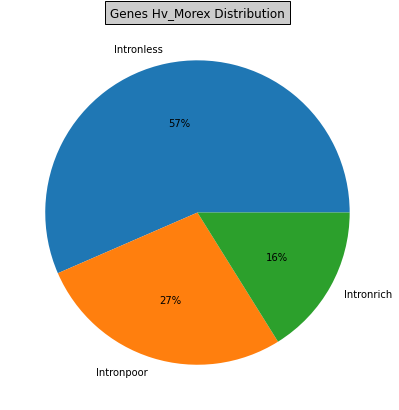

In [27]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Hv_Morex = [46175, 22342, 13170]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Hv_Morex, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_Morex Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [28]:
### --- Creating the list of Hv_Morex gene IDs to check the number of transcripts using command line
intronless_file_Hv_Morex = open('Output/Hv_Morex_intronlessIDs.txt', 'a')
intronpoor_file_Hv_Morex = open('Output/Hv_Morex_intronpoorIDs.txt', 'a')
intronrich_file_Hv_Morex = open('Output/Hv_Morex_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_Morex)):
    if i == len(intronless_Hv_Morex) -1:
        intronless_file_Hv_Morex.write(intronless_Hv_Morex[i])
    else:
        intronless_file_Hv_Morex.write(intronless_Hv_Morex[i] + '\n')
intronless_file_Hv_Morex.close()

for i in range(len(intronpoor_Hv_Morex)):
    if i == len(intronpoor_Hv_Morex) -1:
        intronpoor_file_Hv_Morex.write(intronpoor_Hv_Morex[i])
    else:
        intronpoor_file_Hv_Morex.write(intronpoor_Hv_Morex[i] + '\n')
intronpoor_file_Hv_Morex.close()

for i in range(len(intronrich_Hv_Morex)):
    if i == len(intronrich_Hv_Morex) -1:
        intronrich_file_Hv_Morex.write(intronrich_Hv_Morex[i])
    else:
        intronrich_file_Hv_Morex.write(intronrich_Hv_Morex[i]+'\n')
intronrich_file_Hv_Morex.close()


In [29]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_Morex = ! grep -f Output/Hv_Morex_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_Morex = ! grep -f Output/Hv_Morex_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_Morex = ! grep -f Output/Hv_Morex_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [30]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_Morex = int(n_mRNA_intronless_Hv_Morex[0])/n_intronless_Hv_Morex
print(avg_mRNA_intronless_Hv_Morex)
avg_mRNA_intronpoor_Hv_Morex = int(n_mRNA_intronpoor_Hv_Morex[0])/n_intronpoor_Hv_Morex
print(avg_mRNA_intronpoor_Hv_Morex)
avg_mRNA_intronrich_Hv_Morex = int(n_mRNA_intronrich_Hv_Morex[0])/n_intronrich_Hv_Morex
print(avg_mRNA_intronrich_Hv_Morex)

1.0
1.0027302837704772
1.1702353834472285


### 2.3.4 Extracting introns from UTR regions

In [36]:
### --- Extracting introns from UTR forward Hv_Morex
extract_UTR_introns('Data/Hv_Morex_UTRforw.tsv', 'Output/Hv_Morex_UTRforw_introns.tsv')

In [37]:
### --- Extracting introns from UTR reverse Hv_Morex
extract_UTR_introns('Data/Hv_Morex_UTRrev.tsv', 'Output/Hv_Morex_UTRrev_introns.tsv')

In [38]:
introns_UTR_forw_Hv_Morex = pd.read_csv('Output/Hv_Morex_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [39]:
introns_UTR_rev_Hv_Morex = pd.read_csv('Output/Hv_Morex_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000130.1,intron three_prime_UTR,377002,377104,104
1,ID=HORVU.MOREX.r3.1HG0000350.1,intron five_prime_UTR,1156130,1159354,3226
2,ID=HORVU.MOREX.r3.1HG0001120.1,intron five_prime_UTR,2577943,2580334,2393
3,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3193629,3198818,5191
4,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3198962,3199088,128


In [40]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames_Hv_Morex = [introns_UTR_forw_Hv_Morex, introns_UTR_rev_Hv_Morex]
introns_UTR_Hv_Morex = pd.concat(frames_Hv_Morex)

In [41]:
### --- Performing some basic statistics 
introns_UTR_Hv_Morex['length'].describe()

count     5711.000000
mean       897.227981
std       2447.933245
min         33.000000
25%        119.000000
50%        396.000000
75%        932.000000
max      74239.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

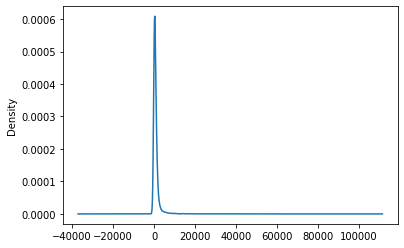

In [42]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_Morex['length'].plot.density()

<AxesSubplot:>

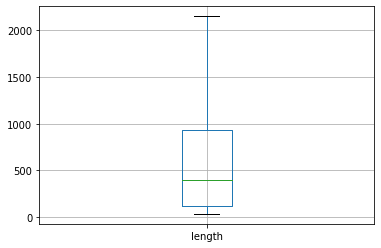

In [43]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_Morex.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [44]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_Morex = introns_UTR_Hv_Morex.loc[introns_UTR_Hv_Morex['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_Morex = introns_UTR_Hv_Morex.loc[introns_UTR_Hv_Morex['type'].isin(['intron five_prime_UTR'])]

In [45]:
introns_UTR3_Hv_Morex

,ID,type,start,end,length
11,ID=HORVU.MOREX.r3.1HG0003090.2,intron three_prime_UTR,5946475,5974459,27986
12,ID=HORVU.MOREX.r3.1HG0003090.6,intron three_prime_UTR,5946475,5974459,27986
24,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14661381,14662100,721
25,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14662182,14662301,121
27,ID=HORVU.MOREX.r3.1HG0007370.2,intron three_prime_UTR,15093762,15093878,118
...,...,...,...,...,...
2676,ID=HORVU.MOREX.r3.7HG0748130.1,intron three_prime_UTR,620827612,620827821,211
2677,ID=HORVU.MOREX.r3.7HG0749430.1,intron three_prime_UTR,623175384,623176311,929
2678,ID=HORVU.MOREX.r3.7HG0749440.1,intron three_prime_UTR,623212429,623212835,408
2682,ID=HORVU.MOREX.r3.7HG0749980.1,intron three_prime_UTR,624202455,624203734,1281


In [46]:
introns_UTR3_Hv_Morex['length'].describe()

count     2012.000000
mean       967.822565
std       3355.354223
min         33.000000
25%        100.000000
50%        208.500000
75%        771.750000
max      74239.000000
Name: length, dtype: float64

In [47]:
introns_UTR5_Hv_Morex

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117
...,...,...,...,...,...
2686,ID=HORVU.MOREX.r3.7HG0751310.1,intron five_prime_UTR,627322202,627322296,96
2687,ID=HORVU.MOREX.r3.7HG0752050.1,intron five_prime_UTR,628813527,628813619,94
2689,ID=HORVU.MOREX.r3.7HG0752950.1,intron five_prime_UTR,632146924,632147308,386
2690,ID=HORVU.MOREX.r3.UnG0753140.1,intron five_prime_UTR,475717,475945,230


In [48]:
introns_UTR5_Hv_Morex['length'].describe()

count     3699.000000
mean       858.829413
std       1768.080234
min         41.000000
25%        142.000000
50%        497.000000
75%        991.000000
max      34933.000000
Name: length, dtype: float64

### 2.3.5 Removing UTR introns from the whole introns dataframe

In [49]:
### --- Checking total introns dataframe 
introns_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102


In [50]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [51]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_Morex = cds_introns_dataframe(introns_Hv_Morex, introns_UTR_Hv_Morex)
introns_cds_Hv_Morex

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
...,...,...,...,...,...
156682,ID=HORVU.MOREX.r3.UnG0816320.1,intron,28904141,28904339,200
156683,ID=HORVU.MOREX.r3.UnG0816640.1,intron,29002646,29003296,652
156684,ID=HORVU.MOREX.r3.UnG0816680.1,intron,29008046,29008730,686
156685,ID=HORVU.MOREX.r3.UnG0816840.1,intron,29079790,29086201,6413


In [52]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_Morex.loc[introns_cds_Hv_Morex['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [53]:
### --- Basic statistics of Hv_Morex introns cds
introns_cds_Hv_Morex['length'].describe()

count    150976.000000
mean        552.505862
std        2509.972190
min          22.000000
25%          92.000000
50%         127.000000
75%         421.000000
max      500805.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

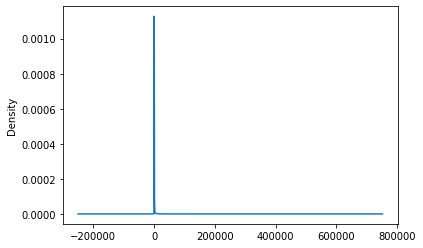

In [54]:
### --- Plotting the distribution of Hv_Morex cds introns length
introns_cds_Hv_Morex['length'].plot.density()

<AxesSubplot:>

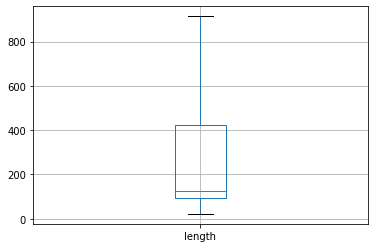

In [55]:
### --- Plotting the boxplot of Hv_Morex cds introns length without outliers
introns_cds_Hv_Morex.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.3.6 Re-organizing files and directories

In [56]:
! ls Data/

Hv_Morex_exon.tsv
Hv_Morex_longread
Hv_Morex_nohashtag.pgsb.Jul2020.csv
Hv_Morex_nohashtag.pgsb.Jul2020.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_Morex_UTRforw.tsv
Hv_Morex_UTRrev.tsv
raw


In [57]:
! mv Data/*tsv Data/Hv_Morex_longread

In [34]:
! mv Data/Hv_Morex_n* Data/Hv_Morex_longread/

In [35]:
! ls Data/Hv_Morex_longread/

Hv_Morex_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.gff3
Hv_MorexHC_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_MorexHC_UTRforw.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexHC_UTRrev.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_MorexLC_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_MorexLC_UTRforw.tsv		     Hv_Morex_UTRforw.tsv
Hv_MorexLC_UTRrev.tsv		     Hv_Morex_UTRrev.tsv
Hv_Morex_nohashtag.pgsb.Jul2020.csv


In [59]:
! ls Output/

Hv_Morex_intronlessIDs.txt  Hv_Morex_longread
Hv_Morex_intronpoorIDs.txt  Hv_Morex_UTRforw_introns.tsv
Hv_Morex_intronrichIDs.txt  Hv_Morex_UTRrev_introns.tsv
Hv_Morex_introns.tsv


In [60]:
! mv Output/*tsv Output/Hv_Morex_longread/

In [61]:
! mv Output/*txt Output/Hv_Morex_longread/

In [62]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt	Hv_Morex_introns.tsv
Hv_MorexHC_intronpoorIDs.txt	Hv_MorexLC_intronlessIDs.txt
Hv_MorexHC_intronrichIDs.txt	Hv_MorexLC_intronpoorIDs.txt
Hv_MorexHC_introns.tsv		Hv_MorexLC_intronrichIDs.txt
Hv_MorexHC_UTRforw_introns.tsv	Hv_MorexLC_introns.tsv
Hv_MorexHC_UTRrev_introns.tsv	Hv_MorexLC_UTRforw_introns.tsv
Hv_Morex_intronlessIDs.txt	Hv_MorexLC_UTRrev_introns.tsv
Hv_Morex_intronpoorIDs.txt	Hv_Morex_UTRforw_introns.tsv
Hv_Morex_intronrichIDs.txt	Hv_Morex_UTRrev_introns.tsv


# 3 Reproducing the same analysis using data of a Pan Genome study

The Pan Genome study I am referring to can be found [here](https://www.nature.com/articles/s41586-020-2947-8). All the data can be found [here](https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/3490162b-3d76-4ba1-b6ee-3eaed5f6b644/2/).

I will firstly perform the analysis on the data within the _Denovo_gene_annotation_ directory and then on the ones within the _Gene_projection_ directory. 

## 3.1 Barke - De novo gene annotation 

### 3.1.1 Collecting Data

In [7]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Barke.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/1f736b6a-20f5-4e48-83c9-a308a51221ee/1/DOWNLOAD

--2021-06-04 11:01:00--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/1f736b6a-20f5-4e48-83c9-a308a51221ee/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58830221 (56M) [text/plain]
Saving to: ‘Data/raw/Barke.gff3’

Data/raw/Barke.gff3 100%[===================>]  56,10M  1,95MB/s    in 31s     

2021-06-04 11:01:31 (1,81 MB/s) - ‘Data/raw/Barke.gff3’ saved [58830221/58830221]



### 3.1.2 Processing Data

In [8]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [9]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Barke.gff3  > Data/Barke_nohashtag.gff3

In [10]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Barke_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Barke_nohashtag.csv

In [11]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Barke = pd.read_csv('Data/Barke_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010
1,chr1H,PGSB,mRNA,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,72210,72399,.,+,0,ID=HORVU.BARKE.r1.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2


In [12]:
### --- Building a separate dataframe containing all exons
exon_Barke = df_Barke.loc[df_Barke['type'].isin(['exon'])]
exon_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2
8,chr1H,PGSB,exon,102846,103475,.,+,.,ID=HORVU.BARKE.r1.1HG0000020.1.exon.1
12,chr1H,PGSB,exon,104616,105062,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.1
14,chr1H,PGSB,exon,105168,105209,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.2


In [13]:
### --- Exporting the exon dataframe to a tsv file 
exon_Barke.to_csv('Data/Barke_exon.tsv',sep='\t',index=False,header=False)

In [14]:
### --- Keeping in a separated dataframe the forward strands
forw_Barke = df_Barke.loc[df_Barke['strand'].isin(['+'])]
forw_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010
1,chr1H,PGSB,mRNA,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,72210,72399,.,+,0,ID=HORVU.BARKE.r1.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2


In [15]:
### --- Keeping in a separated dataframe the reverse strands
rev_Barke = df_Barke.loc[df_Barke['strand'].isin(['-'])]
rev_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSB,gene,104616,112948,.,-,.,ID=HORVU.BARKE.r1.1HG0000030
11,chr1H,PGSB,mRNA,104616,112948,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1
12,chr1H,PGSB,exon,104616,105062,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.1
13,chr1H,PGSB,CDS,104616,105062,.,-,0,ID=HORVU.BARKE.r1.1HG0000030.1.CDS.1
14,chr1H,PGSB,exon,105168,105209,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.2


In [16]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Barke = forw_Barke.loc[df_Barke['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [18]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Barke = rev_Barke.loc[df_Barke['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes


As we see UTRs are not reported within this annotation so we cannot analyze them. We will just focus on the total number of introns. 

### 3.1.3 Extracting introns from the whole genome

In [20]:
### --- Extracting introns from Barke
extract_tot_introns('Data/Barke_exon.tsv', 'Output/Barke_introns.tsv')

In [21]:
introns_Barke = pd.read_csv('Output/Barke_introns.tsv', sep = '\t')
introns_Barke[:100]

,ID,type,start,end,length
0,ID=HORVU.BARKE.r1.1HG0000010.1,intron,72400,72821,423
1,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105063,105167,106
2,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105210,105713,505
3,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105782,105861,81
4,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105905,106005,102
...,...,...,...,...,...
95,ID=HORVU.BARKE.r1.1HG0000150.1,intron,428232,428317,87
96,ID=HORVU.BARKE.r1.1HG0000160.1,intron,436394,436497,105
97,ID=HORVU.BARKE.r1.1HG0000170.1,intron,496838,496909,73
98,ID=HORVU.BARKE.r1.1HG0000170.1,intron,496951,497090,141


In [22]:
### --- Counting introns type in Barke
introns_dictionary_Barke = counting_introns_type(exon_Barke)

In [23]:
n_intronless_Barke, n_intronpoor_Barke, n_intronrich_Barke, intronless_Barke, intronpoor_Barke, intronrich_Barke = splitting_introns_type(introns_dictionary_Barke)

Intronless are: 25166
Intronpoor are: 14852
Intronrich are: 11019


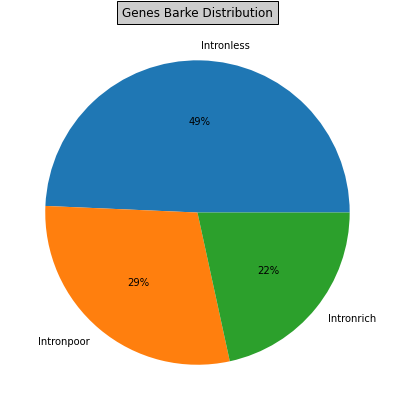

In [24]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Barke = [25166, 14852, 11019]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Barke, labels = genes, autopct='%1.0f%%')
plt.title("Genes Barke Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [25]:
### --- Creating the list of Barke gene IDs to check the number of transcripts using command line
intronless_file_Barke = open('Output/Barke_intronlessIDs.txt', 'a')
intronpoor_file_Barke = open('Output/Barke_intronpoorIDs.txt', 'a')
intronrich_file_Barke = open('Output/Barke_intronrichIDs.txt', 'a')
for i in range(len(intronless_Barke)):
    if i == len(intronless_Barke) -1:
        intronless_file_Barke.write(intronless_Barke[i])
    else:
        intronless_file_Barke.write(intronless_Barke[i] + '\n')
intronless_file_Barke.close()

for i in range(len(intronpoor_Barke)):
    if i == len(intronpoor_Barke) -1:
        intronpoor_file_Barke.write(intronpoor_Barke[i])
    else:
        intronpoor_file_Barke.write(intronpoor_Barke[i] + '\n')
intronpoor_file_Barke.close()

for i in range(len(intronrich_Barke)):
    if i == len(intronrich_Barke) -1:
        intronrich_file_Barke.write(intronrich_Barke[i])
    else:
        intronrich_file_Barke.write(intronrich_Barke[i]+'\n')
intronrich_file_Barke.close()

In [28]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Barke = ! grep -f Output/Barke_intronlessIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Barke = ! grep -f Output/Barke_intronpoorIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Barke = ! grep -f Output/Barke_intronrichIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [29]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Barke = int(n_mRNA_intronless_Barke[0])/n_intronless_Barke
print(avg_mRNA_intronless_Barke)
avg_mRNA_intronpoor_Barke = int(n_mRNA_intronpoor_Barke[0])/n_intronpoor_Barke
print(avg_mRNA_intronpoor_Barke)
avg_mRNA_intronrich_Barke = int(n_mRNA_intronrich_Barke[0])/n_intronrich_Barke
print(avg_mRNA_intronrich_Barke)

1.0
1.0
1.0


It seems there are no transcripts undergoing alternative splicing. This is probably due to a poor annotation. 

In [30]:
### --- Basic statistics of Barke introns
introns_Barke['length'].describe()

count    118377.000000
mean        521.125354
std        1624.109541
min          22.000000
25%          94.000000
50%         132.000000
75%         433.000000
max      137958.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

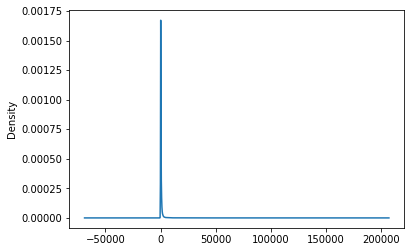

In [31]:
### --- Plotting the distribution of Barke introns length
introns_Barke['length'].plot.density()

<AxesSubplot:>

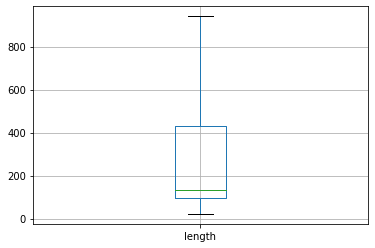

In [32]:
### --- Plotting the boxplot of Barke introns length without outliers
introns_Barke.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.1.4 Re-organizing files and directories

In [36]:
! ls Data/

Barke_exon.tsv	     Barke_nohashtag.gff3  raw
Barke_nohashtag.csv  Hv_Morex_longread


In [39]:
! mkdir Data/Barke

In [40]:
! mv Data/Barke_* Data/Barke/ 

In [42]:
! ls Data/Barke/

Barke_exon.tsv	Barke_nohashtag.csv  Barke_nohashtag.gff3


In [43]:
! ls Output/

Barke_intronlessIDs.txt  Barke_intronrichIDs.txt  Hv_Morex_longread
Barke_intronpoorIDs.txt  Barke_introns.tsv


In [44]:
! mkdir Output/Barke

In [45]:
! mv Output/Barke_* Output/Barke/

In [46]:
! ls Output/Barke/

Barke_intronlessIDs.txt  Barke_intronrichIDs.txt
Barke_intronpoorIDs.txt  Barke_introns.tsv
